In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/dcsass-dataset/DCSASS Dataset/Labels/Shoplifting.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Import necessary libraries  
import pandas as pd
import numpy as np

# Load the labels dataset from the .csv file
df = pd.read_csv('/kaggle/input/dcsass-dataset/DCSASS Dataset/Labels/Shoplifting.csv')

In [4]:
# Rename first column that contains the video paths
df['video_path'] = df['Shoplifting001_x264_0']
# Drop the unnecessary columns
df = df.drop(columns=['Shoplifting001_x264_0','Shoplifting'])
# Rename the columns for clarity
df = df.rename(columns={'0': 'label'})
df['video_path'] = df['video_path'].apply(lambda x: f"{x}.mp4")

In [5]:
from sklearn.model_selection import train_test_split
# Assuming df is your DataFrame and 'video_path' is the column with the video file paths
video_paths = df['video_path'].tolist()

# Split the dataset into training and temporary sets
train_paths, temp_paths = train_test_split(video_paths, test_size=0.4, random_state=42)

# Further split the temporary set into validation and test sets
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

# Now you have your splits
print("Number of training videos:", len(train_paths))
print("Number of validation videos:", len(val_paths))
print("Number of test videos:", len(test_paths))

Number of training videos: 537
Number of validation videos: 179
Number of test videos: 179


In [6]:
train_df = df[df['video_path'].isin(train_paths)]
val_df = df[df['video_path'].isin(val_paths)]
test_df = df[df['video_path'].isin(test_paths)]

In [7]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 43.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.5 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is inc

In [8]:
import cv2
import mediapipe as mp
from tqdm import tqdm
import os
import numpy as np

# Initialize MediaPipe Pose.
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Function to process videos and save augmented images
def process_videos(df, split_name, augment=True):
    # Create a directory to save the processed images in the /kaggle/working directory
    output_dir = os.path.join('/kaggle/working', f"{split_name}_processed_images")
    os.makedirs(output_dir, exist_ok=True)

    for video_file in tqdm(df['video_path'], desc=f"Processing {split_name} videos"):
        cap = cv2.VideoCapture(video_file)
        frame_count = 0

        with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while cap.isOpened():
                success, image = cap.read()
                if not success:
                    print(f"Finished processing {video_file} from {split_name} set.")
                    break

                # Convert the BGR image to RGB.
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Process the image and find pose landmarks.
                results = pose.process(image)

                # Draw the pose annotation on the image.
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                # Augment the image if augment is True
                if augment:
                    # Example augmentation: horizontal flipping
                    image = cv2.flip(image, 1)

                # Save the image to disk
                output_path = os.path.join(output_dir, f"{os.path.basename(video_file).split('.')[0]}_frame_{frame_count}.jpg")
                cv2.imwrite(output_path, image)
                frame_count += 1

        cap.release()

# Process videos from each split with data augmentation
process_videos(train_df, 'Training', augment=True)
process_videos(val_df, 'Validation', augment=True)  # No augmentation for validation
process_videos(test_df, 'Testing', augment=False)    # No augmentation for testing

print("Finished processing all videos with data augmentation.")

Processing Training videos:   0%|          | 0/537 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730809026.024166     108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730809026.075548     108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing Training videos:   0%|          | 1/537 [00:00<01:58,  4.51it/s]W0000 00:00:1730809026.184991     111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730809026.208413     111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing Training videos:   0%|          | 2/537 [00:00<01:30,  5.92it/s

Finished processing all videos with data augmentation.


In [9]:
root = '/kaggle/input/dcsass-dataset/DCSASS Dataset/Shoplifting'

In [10]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re

shoplifting = 0
def preprocess_image(image):
    # Resize the image to the expected input size of the MobileNet model (128x128)
    image = cv2.resize(image, (128, 128))
    # Normalize the pixel values to the range [0, 1]
    image = image / 255.0
    # Convert the image to a tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    return image

def preprocess_data(df):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        # Remove substrings like "_11" from video_path using regex
        video_path = re.sub(r'_\d+', '', root + '/' + row['video_path'])
        cap = cv2.VideoCapture(video_path+ '/' +row['video_path'])
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = preprocess_image(frame)
            images.append(frame)
            labels.append(row['label'])
        
        cap.release()
    
    images = tf.stack(images)
    # Convert the list of numerical labels to a tensor
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    print(len(images))
    print(len(labels))
    print(labels)
    return images, labels

In [11]:
with tf.device('/gpu:1'):
    train_images, train_labels = preprocess_data(train_df)
    val_images, val_labels = preprocess_data(val_df)

36480
36480
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(36480,), dtype=float32)
12240
12240
tf.Tensor([0. 0. 0. ... 1. 1. 1.], shape=(12240,), dtype=float32)


In [12]:
import tensorflow as tf
import tensorflow_hub as hub

# Conditionally import tf_keras as keras for TensorFlow 3.x compatibility
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
    import tf_keras as keras
else:
    keras = tf.keras

# Load the MobileNet model from TensorFlow Hub
model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
m = keras.Sequential([
    hub.KerasLayer(model_url),
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),  # Adding L2 regularization
    keras.layers.Dropout(0.3),  # Add dropout with a dropout rate of 0.3
    keras.layers.Dense(1, activation='sigmoid')
])

# Define the optimizer with the specified learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and the specified optimizer
m.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 3 == 0 and epoch > 0:
        lr = lr * 0.5  # Reduce learning rate by half every 3 epochs
    return lr

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

In [13]:
# Train the model with callbacks
history = m.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels),
                callbacks=[ lr_scheduler_callback])

Epoch 1/15
1140/1140 [==============================] - 122s 75ms/step - loss: 2.2100 - accuracy: 0.8222 - val_loss: 1.5962 - val_accuracy: 0.8831 - lr: 1.0000e-04
Epoch 2/15
1140/1140 [==============================] - 108s 95ms/step - loss: 1.3375 - accuracy: 0.8676 - val_loss: 1.0365 - val_accuracy: 0.9014 - lr: 1.0000e-04
Epoch 3/15
1140/1140 [==============================] - 86s 76ms/step - loss: 0.8795 - accuracy: 0.8863 - val_loss: 0.7343 - val_accuracy: 0.8915 - lr: 1.0000e-04
Epoch 4/15
1140/1140 [==============================] - 109s 95ms/step - loss: 0.6543 - accuracy: 0.8965 - val_loss: 0.6515 - val_accuracy: 0.8895 - lr: 5.0000e-05
Epoch 5/15
1140/1140 [==============================] - 107s 94ms/step - loss: 0.5509 - accuracy: 0.9036 - val_loss: 0.5579 - val_accuracy: 0.8852 - lr: 5.0000e-05
Epoch 6/15
1140/1140 [==============================] - 87s 76ms/step - loss: 0.4693 - accuracy: 0.9121 - val_loss: 0.4877 - val_accuracy: 0.8899 - lr: 5.0000e-05
Epoch 7/15
1140/11

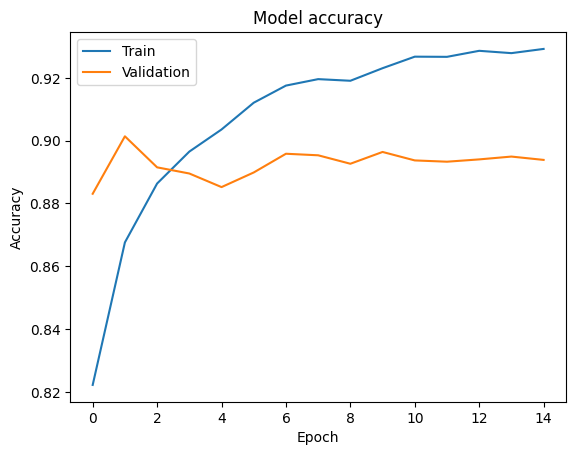

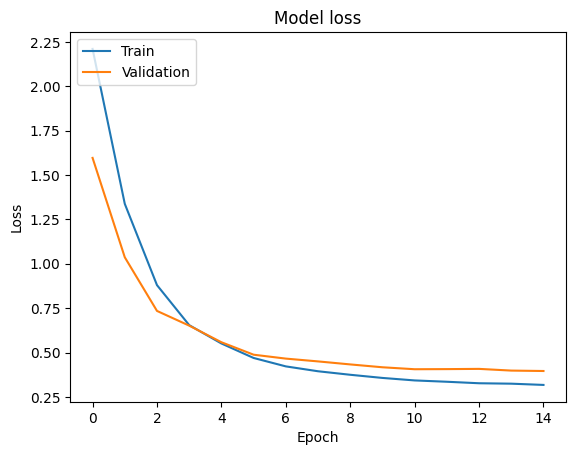

In [14]:
import matplotlib.pyplot as plt

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
test_images, test_labels = preprocess_data(test_df)
predictions = m.predict(test_images, verbose=0)

12600
12600
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(12600,), dtype=float32)


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [16]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# Assuming predictions are probabilities
threshold = 0.5  # Adjust based on your specific use case
predicted_labels = (predictions > threshold).astype(int)

# Now, both test_labels and predicted_labels are in the correct format for classification
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='binary')
conf_matrix = confusion_matrix(test_labels, predicted_labels)
accuracy = accuracy_score(test_labels, predicted_labels)  # Calculate accuracy

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")

Precision: 0.629883843717001
Recall: 0.576328502415459
F1 Score: 0.6019172552976793
Confusion Matrix:
[[9829  701]
 [ 877 1193]]
Accuracy: 0.8747619047619047


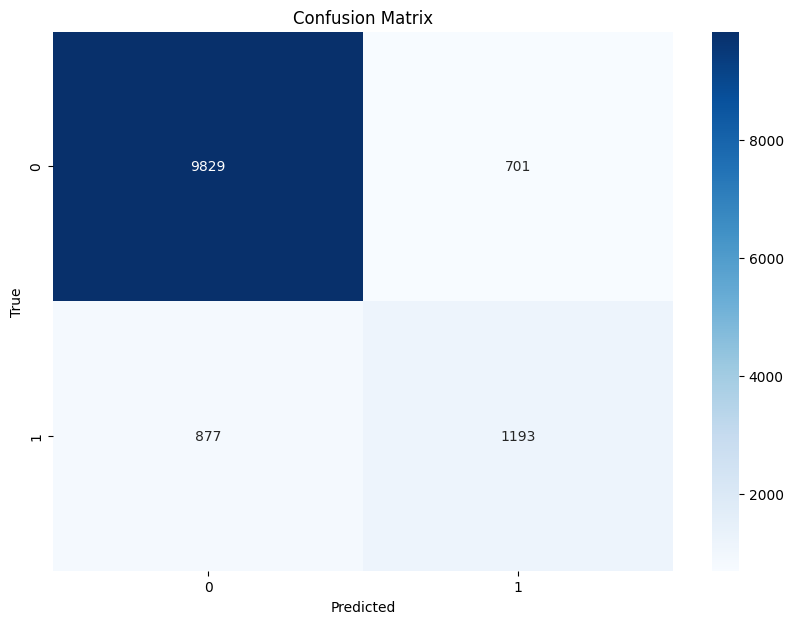

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()